In [78]:
# Importación de bibliotecas estándar
import numpy as np
import pandas as pd

# Importación de bibliotecas para visualización
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.patches as mpatches

# Importando itertools para generar combinaciones de columnas
import itertools 

# Importando la función seasonal_decompose para la descomposición de series temporales
from statsmodels.tsa.seasonal import seasonal_decompose

# Importación de herramientas para modelos de machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import learning_curve
from sklearn.metrics import roc_auc_score, log_loss
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from imblearn.under_sampling import RandomUnderSampler

# Importación de módulo personalizado
import payments_manager as pm

cr_cp = pm.df('cr_cp')
fe_cp = pm.df('fe_cp')
df_jo = pm.df('df_jo')
#df_jo = pm.sort("df_jo", ["id_cr"]).reset_index()
#df_jo = df_jo.drop(columns=['index'])
#df_jo = df_jo.drop(columns=['Mes_created_at'])
#df_jo_cp = df_jo.copy()
df_jo = pm.sort("df_jo", ["id_cr"]).reset_index()
df_jo = df_jo.drop(columns=['index'])
#df_jo.info()


In [79]:
# Datos de partida
pd.options.display.max_columns = None
pm.format_to_dates(df_jo, time_format='d') # 'min','s'
df = pm.df('df_hyper')
display(df)

,user_id,created_at_slot,created_at_dow,amount,n_fees,n_backs,n_recovery,n_inc_back,n_inc_fees,transfer_type,charge_moment,n_cr_fe_w,inflation,GBP_EUR,BTC_GBP,unemploy_rate,needs_m_check_recov
0,47,13,1,1.0,0,0,0,1,0,regular,NaN,0,1.3,1.16935,6347.577148,3.9,1
1,99001309,14,0,100.0,0,1,0,0,0,regular,NaN,1,1.3,1.18803,5630.115723,4.0,0
2,804,19,1,100.0,0,0,0,1,0,regular,NaN,0,1.3,1.18800,5543.707520,4.0,1
3,812,19,1,100.0,0,0,1,1,0,regular,NaN,0,1.3,1.18800,5543.707520,4.0,1
4,191,19,1,100.0,0,0,0,1,0,regular,NaN,0,1.3,1.18800,5543.707520,4.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32087,55916,23,6,50.0,2,2,0,1,0,instant,after,1,0.7,0.00000,10627.522461,5.3,0
32088,39339,23,6,100.0,3,3,0,0,0,instant,after,1,0.7,0.00000,10627.522461,5.3,0
32089,24505,23,6,50.0,2,2,3,4,4,instant,NaN,0,0.7,0.00000,10627.522461,5.3,1
32090,100781,23,6,60.0,1,1,0,0,0,instant,after,1,0.7,0.00000,10627.522461,5.3,0


In [80]:
#VERIFICACION DE BALANCEO DE CLASES

# value_counts_all = df_jo['needs_m_check_recov'].value_counts()
# total_all = value_counts_all[0] + value_counts_all[1]
# needs_manual_all = (value_counts_all[1] / total_all) * 100
# print(f'Porcentaje de operaciones con needs_m_check del total de clientes: {needs_manual_all:.2f} %')

# Separar características y variable objetivo
X = df.drop(columns=['needs_m_check_recov'])  # Todas las columnas excepto la target
y = df['needs_m_check_recov']  # Columna objetivo

# Instanciar RandomUnderSampler
rus = RandomUnderSampler(random_state=42)

# Aplicar el muestreo
X_resampled, y_resampled = rus.fit_resample(X, y)

# Reconstruir un nuevo dataframe balanceado
df_balanced = pd.concat([pd.DataFrame(X_resampled, columns=X.columns), 
                          pd.DataFrame(y_resampled, columns=['needs_m_check_recov'])], axis=1)

# Verificar el balanceo
#print(f"{df_resampled.value_counts()}")
print(f"tamaño original: {len(df_jo)} tamaño balanceado: {len(df_balanced)}")
print(df_balanced['needs_m_check_recov'].value_counts())
df_balanced 

tamaño original: 32092 tamaño balanceado: 30608
needs_m_check_recov
0    15304
1    15304
Name: count, dtype: int64


/home/albagd/ProyectoPastaLoca2/myenv/lib/python3.10/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/home/albagd/ProyectoPastaLoca2/myenv/lib/python3.10/site-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


,user_id,created_at_slot,created_at_dow,amount,n_fees,n_backs,n_recovery,n_inc_back,n_inc_fees,transfer_type,charge_moment,n_cr_fe_w,inflation,GBP_EUR,BTC_GBP,unemploy_rate,needs_m_check_recov
1,99001309,14,0,100.0,0,1,0,0,0,regular,NaN,1,1.3,1.18803,5630.115723,4.0,0
7,735,19,1,100.0,0,1,0,0,0,regular,NaN,1,1.3,1.18800,5543.707520,4.0,0
9,140,19,1,100.0,0,1,0,0,0,regular,NaN,1,1.3,1.18800,5543.707520,4.0,0
10,1145,19,1,100.0,0,1,0,0,0,regular,NaN,1,1.3,1.18800,5543.707520,4.0,0
13,984,19,1,30.0,0,1,0,0,0,regular,NaN,1,1.3,1.18800,5543.707520,4.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13553,33222,21,2,100.0,0,0,0,6,0,instant,NaN,0,0.2,1.11189,8880.038086,5.0,1
14996,2656,13,3,100.0,1,4,2,1,2,regular,NaN,0,0.2,1.10670,8984.978516,5.0,1
29830,99024734,16,0,100.0,1,1,0,0,1,instant,before,1,0.7,1.10162,10046.040039,5.2,1
31153,99016938,9,3,50.0,0,0,0,1,0,instant,NaN,0,0.7,1.10554,10391.864258,5.2,1


In [81]:
X_log_L=df_balanced
y_log_L=y_resampled

In [77]:
X_log_L.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30608 entries, 1 to 16549
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   user_id                30608 non-null  int64  
 1   created_at_slot        30608 non-null  int32  
 2   created_at_dow         30608 non-null  int32  
 3   amount                 30608 non-null  float64
 4   n_fees                 30608 non-null  int64  
 5   n_backs                30608 non-null  int64  
 6   n_recovery             30608 non-null  int64  
 7   n_inc_back             30608 non-null  int64  
 8   n_inc_fees             30608 non-null  int64  
 9   n_cr_fe_w              30608 non-null  int64  
 10  inflation              30608 non-null  float64
 11  GBP_EUR                30608 non-null  float64
 12  BTC_GBP                30608 non-null  float64
 13  unemploy_rate          30608 non-null  object 
 14  transfer_type_regular  30608 non-null  int64  
 15  charge_

In [44]:
# Convertir las columnas de tipo timedelta64
#for col in X_log_L.select_dtypes(include=['timedelta64']).columns:
#    X_log_L[col] = X_log_L[col].apply(lambda x: x / pd.to_timedelta(1, unit='d') if pd.notnull(x) else None)

In [45]:
# Convertir las columnas de tipo datetime64
#for col in X_log_L.select_dtypes(include=['datetime64']).columns:
#    X_log_L[col] = X_log_L[col].apply(lambda x: x.timestamp() if pd.notnull(x) else None)

In [82]:
# One Hot econding para pasar a numéricas todas las categóricas
X_log_L = pd.get_dummies(X_log_L, columns=['transfer_type'], drop_first=True, dtype=int)

In [83]:
X_log_L = pd.get_dummies(X_log_L, columns= ['charge_moment'], drop_first=True, dtype=int)

In [84]:
# Rellenar NaN con 0
X_log_L = X_log_L.fillna(0)

In [76]:
X_log_L.describe()

,user_id,created_at_slot,created_at_dow,amount,n_fees,n_backs,n_recovery,n_inc_back,n_inc_fees,n_cr_fe_w,inflation,GBP_EUR,BTC_GBP,transfer_type_regular,charge_moment_before
count,3.060800e+04,30608.000000,30608.000000,30608.000000,30608.000000,30608.000000,30608.000000,30608.000000,30608.000000,30608.000000,30608.000000,30608.000000,30608.000000,30608.000000,30608.000000
mean,7.705842e+06,12.653261,2.753627,83.548092,0.992061,1.478862,0.688676,0.907181,1.060246,1.020648,0.633596,0.883235,8395.827905,0.389637,0.135978
std,2.647025e+07,5.263517,1.827636,25.923598,1.130564,1.395051,1.681023,1.751953,2.153462,0.867716,0.286327,0.445419,1043.274245,0.487676,0.342770
min,3.400000e+01,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.200000,0.000000,3954.907959,0.000000,0.000000
25%,1.252050e+04,9.000000,1.000000,50.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.500000,1.090690,7574.018555,0.000000,0.000000
50%,2.700900e+04,13.000000,3.000000,100.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.700000,1.102660,8435.253906,0.000000,0.000000
75%,5.559925e+04,17.000000,4.000000,100.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,0.700000,1.108140,8966.680664,1.000000,0.000000
max,9.903044e+07,23.000000,6.000000,200.000000,15.000000,11.000000,28.000000,21.000000,33.000000,13.000000,1.800000,1.204510,10645.804688,1.000000,1.000000


In [85]:
# Visualización datos antes del escalador
display(X_log_L.head(10))

# Sacamos la variable objetivo que no se va a escalar
y= X_log_L['needs_m_check_recov'].copy()
X_log_L = X_log_L.drop(columns=['needs_m_check_recov'])

# Crear el escalador en este caso STANDARDSCALER
scaler = StandardScaler()

# Estandarizar todas las columnas
normalizado = scaler.fit_transform(X_log_L)

# Convertir de nuevo a DataFrame, preservando nombres de columnas e índices
X = pd.DataFrame(normalizado, columns=X_log_L.columns, index=df_balanced.index)

# Visualización datos después del escalador
display(X.head(10))

,user_id,created_at_slot,created_at_dow,amount,n_fees,n_backs,n_recovery,n_inc_back,n_inc_fees,n_cr_fe_w,inflation,GBP_EUR,BTC_GBP,unemploy_rate,needs_m_check_recov,transfer_type_regular,charge_moment_before
1,99001309,14,0,100.0,0,1,0,0,0,1,1.3,1.18803,5630.115723,4.0,0,1,0
7,735,19,1,100.0,0,1,0,0,0,1,1.3,1.18800,5543.707520,4.0,0,1,0
9,140,19,1,100.0,0,1,0,0,0,1,1.3,1.18800,5543.707520,4.0,0,1,0
10,1145,19,1,100.0,0,1,0,0,0,1,1.3,1.18800,5543.707520,4.0,0,1,0
13,984,19,1,30.0,0,1,0,0,0,1,1.3,1.18800,5543.707520,4.0,0,1,0
16,895,20,1,100.0,0,1,0,0,0,1,1.3,1.18800,5543.707520,4.0,0,1,0
17,227,20,1,100.0,0,1,0,0,0,1,1.3,1.18800,5543.707520,4.0,0,1,0
19,99004217,22,1,80.0,0,1,0,0,0,1,1.3,1.18800,5543.707520,4.0,0,1,0
20,1257,1,2,100.0,0,1,0,0,0,1,1.3,1.18365,5468.038086,4.0,0,1,0
21,205,2,2,100.0,0,1,0,0,0,1,1.3,1.18365,5468.038086,4.0,0,1,0


,user_id,created_at_slot,created_at_dow,amount,n_fees,n_backs,n_recovery,n_inc_back,n_inc_fees,n_cr_fe_w,inflation,GBP_EUR,BTC_GBP,unemploy_rate,transfer_type_regular,charge_moment_before
1,3.449040,0.255867,-1.506685,0.634641,-0.877507,-0.343263,-0.409684,-0.51782,-0.492353,-0.023796,2.327459,0.684299,-2.651036,-2.645363,1.251596,-0.396708
7,-0.291090,1.205818,-0.959521,0.634641,-0.877507,-0.343263,-0.409684,-0.51782,-0.492353,-0.023796,2.327459,0.684232,-2.733861,-2.645363,1.251596,-0.396708
9,-0.291113,1.205818,-0.959521,0.634641,-0.877507,-0.343263,-0.409684,-0.51782,-0.492353,-0.023796,2.327459,0.684232,-2.733861,-2.645363,1.251596,-0.396708
10,-0.291075,1.205818,-0.959521,0.634641,-0.877507,-0.343263,-0.409684,-0.51782,-0.492353,-0.023796,2.327459,0.684232,-2.733861,-2.645363,1.251596,-0.396708
13,-0.291081,1.205818,-0.959521,-2.065646,-0.877507,-0.343263,-0.409684,-0.51782,-0.492353,-0.023796,2.327459,0.684232,-2.733861,-2.645363,1.251596,-0.396708
16,-0.291084,1.395808,-0.959521,0.634641,-0.877507,-0.343263,-0.409684,-0.51782,-0.492353,-0.023796,2.327459,0.684232,-2.733861,-2.645363,1.251596,-0.396708
17,-0.291109,1.395808,-0.959521,0.634641,-0.877507,-0.343263,-0.409684,-0.51782,-0.492353,-0.023796,2.327459,0.684232,-2.733861,-2.645363,1.251596,-0.396708
19,3.449150,1.775788,-0.959521,-0.136870,-0.877507,-0.343263,-0.409684,-0.51782,-0.492353,-0.023796,2.327459,0.684232,-2.733861,-2.645363,1.251596,-0.396708
20,-0.291071,-2.214005,-0.412357,0.634641,-0.877507,-0.343263,-0.409684,-0.51782,-0.492353,-0.023796,2.327459,0.674465,-2.806393,-2.645363,1.251596,-0.396708
21,-0.291110,-2.024014,-0.412357,0.634641,-0.877507,-0.343263,-0.409684,-0.51782,-0.492353,-0.023796,2.327459,0.674465,-2.806393,-2.645363,1.251596,-0.396708


In [86]:
X=X[['n_inc_fees','n_recovery','n_fees','n_backs','n_cr_fe_w','BTC_GBP']]

Coeficientes del modelo de regresión logística (ordenados por magnitud):
n_recovery: 2.74681192
n_inc_fees: 2.65582376
n_backs: -1.36121189
n_cr_fe_w: -1.07176228
n_fees: -0.68551643
BTC_GBP: -0.14422383

Multiplicadores de odds (elevando exp a los coeficientes):
n_recovery: 15.59284130
n_inc_fees: 14.23670886
n_backs: 0.25634992
n_cr_fe_w: 0.34240457
n_fees: 0.50382997
BTC_GBP: 0.86569396


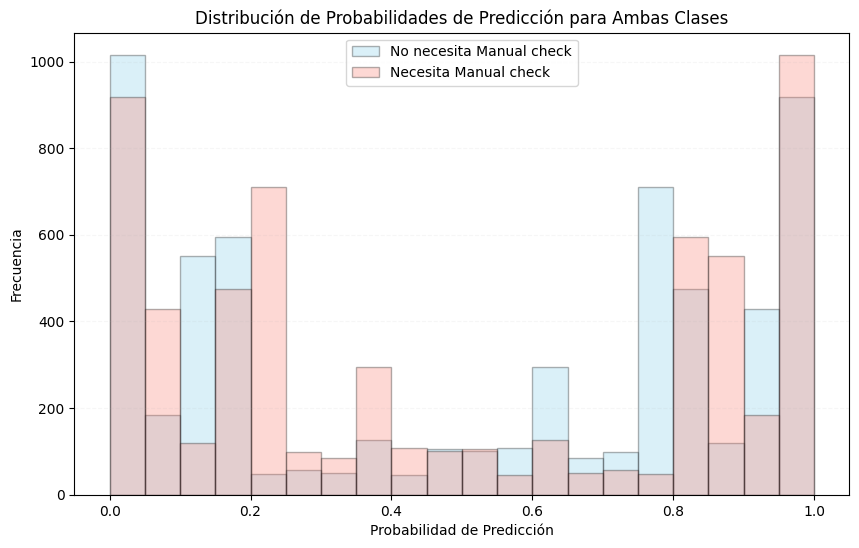

Accuracy: 0.919797451813133
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.96      0.92      3124
           1       0.95      0.88      0.92      2998

    accuracy                           0.92      6122
   macro avg       0.92      0.92      0.92      6122
weighted avg       0.92      0.92      0.92      6122



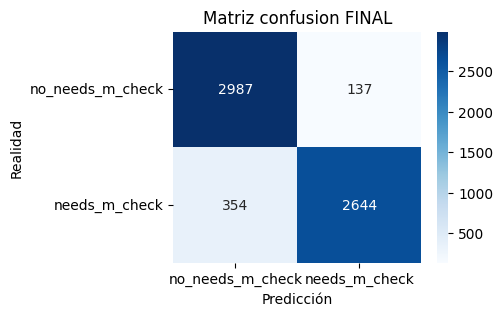

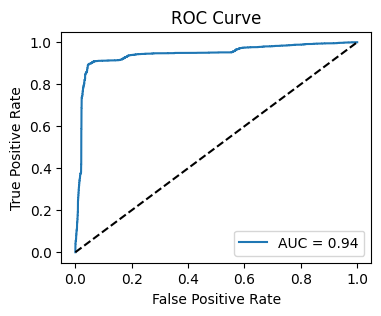

In [87]:
# Pasamos MODELO DE REGRESIÓN LOGISTICA BASE, con las caracteristicas de selección MANUAL y SIN BALANCEO DE CARGAS.

# Obtener los nombres de las características
feature_names = X.columns

# Divide los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=42)

# Crea el clasificador de regresión logística. El 'liblinear' usa metodo de optimización de minimos cuadrados generalizados (L2) y soporta la regularización L1 y L2
clf = LogisticRegression(solver="liblinear")

# Entrena el clasificador
clf.fit(X_train, y_train)

# Realiza predicciones sobre el conjunto de prueba
predicciones = clf.predict(X_test)

# Genera las probabilidades de predicción
predicciones_probabilidades = clf.predict_proba(X_test)

# Muestra las primeras 10 probabilidades de predicción
#predicciones_probabilidades[:10]

# Obtén los coeficientes y asigna los nombres de las características
coeficientes = clf.coef_[0]  # clf.coef_ es un array bidimensional, tomamos la primera fila
feature_coef = list(zip(feature_names, coeficientes))

# Ordena las características por el valor absoluto del coeficiente en orden descendente
feature_coef_sorted = sorted(feature_coef, key=lambda x: abs(x[1]), reverse=True)

# Imprime cada variable junto con su coeficiente ordenado
print("Coeficientes del modelo de regresión logística (ordenados por magnitud):")
for feature, coef in feature_coef_sorted:
    print(f"{feature}: {coef:.8f}")
    
# Convertir coeficientes a multiplicadores de odds
feature_odds = [(feature, np.exp(coef)) for feature, coef in feature_coef_sorted]

# Imprimir los resultados
print("\nMultiplicadores de odds (elevando exp a los coeficientes):")
for feature, odds in feature_odds:
    print(f"{feature}: {odds:.8f}")
    
# Crea un histograma de las probabilidades de predicción para ambas clases
plt.figure(figsize=(10, 6)) 

# # Histograma para la clase negativa (no need manual check)
plt.hist(predicciones_probabilidades[:, 0], bins=20, color="skyblue", edgecolor="black", alpha=0.3, label="No necesita Manual check")
# Histograma para la clase positiva ( need manual check)
plt.hist(predicciones_probabilidades[:, 1], bins=20, color="salmon", edgecolor="black", alpha=0.3, label="Necesita Manual check")
# Título y etiquetas de los ejes
plt.title("Distribución de Probabilidades de Predicción para Ambas Clases")
plt.xlabel("Probabilidad de Predicción")
plt.ylabel("Frecuencia")
plt.legend(loc="upper center") 
# Muestra la leyenda en el gráfico
plt.grid(axis="y", linestyle="--", alpha=0.1)
plt.show()

# Evaluate model performance
print("Accuracy:", clf.score(X_test, y_test))  # Accuracy score
print("Classification Report:\n", classification_report(y_test, predicciones))  # Classification report

# Genera la matriz de confusión
matriz_confusion = confusion_matrix(y_test, predicciones)
columnas = ['no_needs_m_check', 'needs_m_check'] # 0 para No necesita manual check y 1 para Sí necesita manual check

# Visualiza la matriz de confusión utilizando un mapa de calor

plt.figure(figsize=(4, 3))
sns.heatmap(matriz_confusion, annot=True, fmt='d', cmap='Blues', xticklabels=columnas, yticklabels=columnas)
plt.title('Matriz confusion FINAL')
plt.xlabel("Predicción")
plt.ylabel("Realidad")
plt.show()

plt.figure(figsize=(4, 3))
fpr, tpr, thresholds = roc_curve(y_test, predicciones_probabilidades[:, 1])
plt.plot(fpr, tpr, label=f"AUC = {auc(fpr, tpr):.2f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

Total de muestras: 500
500


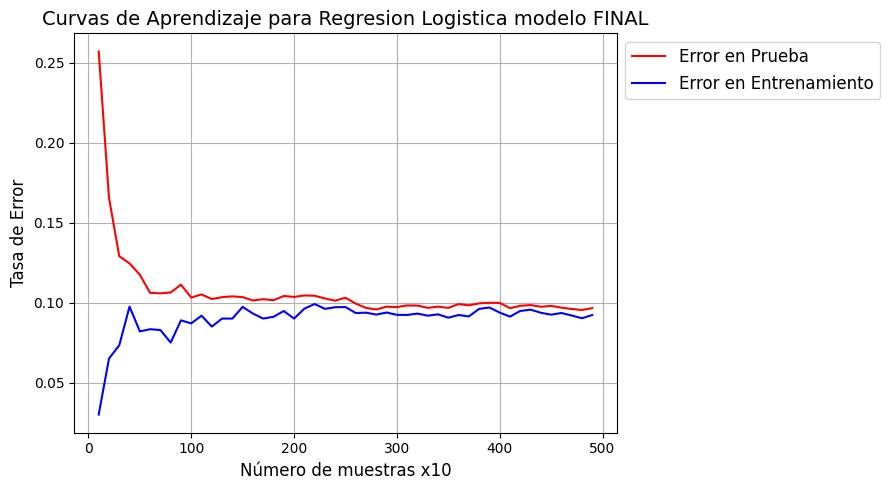

In [88]:
# Graficar curvas de error. 

np.random.seed(42)
# Parámetros
MAXN = 500 # len(X)  # Total de muestras disponibles
steps = 10  # Tamaño de incremento del conjunto de entrenamiento
iterations = 10  # Número de iteraciones para suavizar los resultados
print(f"Total de muestras: {MAXN}")

# Divide los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2) #, random_state=42)
#display(X_test)
#display(y_test)

print(f"{(MAXN // steps) * steps + 0 }")

# Calcular el número de columnas
cols = list(range(steps, (MAXN // steps) * steps, steps))

# Inicializamos los DataFrames para almacenar los errores
test_errors = pd.DataFrame(np.zeros((iterations, len(cols))), columns=cols)
train_errors = pd.DataFrame(np.zeros((iterations, len(cols))), columns=cols)

# Generamos los errores promedios por iteración
for iteration in range(iterations):
    # Mezclamos los datos
    data = pd.concat([X, y], axis=1).sample(frac=1).reset_index(drop=True)
    X_shuffled = data[X.columns]
    y_shuffled = data[y.name]
    
    for N in range(steps, MAXN, steps):
        j = (N // steps) - 1  # Índice para almacenar resultados
        
        # Tomar un subconjunto de datos para entrenamiento
        X_subset = X_shuffled.iloc[:N, :]
        y_subset = y_shuffled.iloc[:N]
        
        # Crear y entrenar el modelo de regresión logística
        clf = LogisticRegression(solver="liblinear", max_iter=1000)
        clf.fit(X_subset, y_subset)
        
        # Evaluar el modelo en el conjunto de prueba y calcular la tasa de error.
        test_errors.iloc[iteration, j] = 1 - metrics.accuracy_score(clf.predict(X_test), y_test)
        # Evaluar el modelo en el conjunto de entrenamiento y calcular la tasa de error.
        train_errors.iloc[iteration, j] = 1 - metrics.accuracy_score(clf.predict(X_subset), y_subset)

# Promediar las tasas de error a lo largo de las iteraciones para obtener una curva de aprendizaje más estable.
mean_test_error = test_errors.mean(axis=0)
mean_train_error = train_errors.mean(axis=0)

# Graficar las curvas de aprendizaje: tasa de error en prueba y entrenamiento.
plt.figure(figsize=(9, 5))
plt.plot(mean_test_error, 'r', label='Error en Prueba') # Error en el conjunto de prueba.
plt.plot(mean_train_error, 'b', label='Error en Entrenamiento') # Error en el conjunto de entrenamiento.

# Configurar etiquetas, título y leyenda.
plt.xlabel('Número de muestras x10', fontsize=12)
plt.ylabel('Tasa de Error', fontsize=12)
plt.title('Curvas de Aprendizaje para Regresion Logistica modelo FINAL', fontsize=14)
plt.legend(loc='upper left', fontsize=12, bbox_to_anchor=(1, 1))

# Mostrar la gráfica con las curvas de error.
plt.grid(True)
plt.tight_layout() # Ajustar la distribución para evitar que las etiquetas se corten.
plt.show()

In [89]:
# Probar modificando el umbral. Cambio a 0.4 (por ejemplo)
umbral = 0.4
predicciones_modificadas = (predicciones_probabilidades[:, 1] >= umbral).astype(int)

Accuracy: 0.9152237830774257
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.92      0.92      3124
           1       0.91      0.91      0.91      2998

    accuracy                           0.91      6122
   macro avg       0.91      0.91      0.91      6122
weighted avg       0.91      0.91      0.91      6122



Text(20.581597222222214, 0.5, 'Realidad')

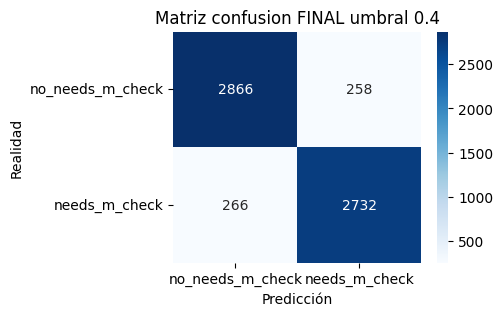

In [90]:
# Evaluate model performance con umbral modificado
print("Accuracy:", clf.score(X_test, y_test))  # Accuracy score
print("Classification Report:\n", classification_report(y_test, predicciones_modificadas))  # Classification report

# Genera la matriz de confusión
matriz_confusion2 = confusion_matrix(y_test, predicciones_modificadas)
columnas = ['no_needs_m_check', 'needs_m_check'] # 0 para No necesita manual check y 1 para Sí necesita manual check

# Visualiza la matriz de confusión utilizando un mapa de calor
plt.figure(figsize=(4, 3))
sns.heatmap(matriz_confusion2, annot=True, fmt='d', cmap='Blues', xticklabels=columnas, yticklabels=columnas)
plt.title('Matriz confusion FINAL umbral 0.4')
plt.xlabel("Predicción")
plt.ylabel("Realidad")

In [56]:
# Cálculo porcentaje de Falsos Negativos y de Falsos Positivos

# Extraer los valores de la matriz de confusión
TN, FP, FN, TP = matriz_confusion.ravel()

# Calcular el porcentaje de Falsos Negativos
porcentaje_FN = (FN / (FN + TP)) * 100

# Calcular el porcentaje de Falsos Positivos
porcentaje_FP = (FP / (FP + TN)) * 100

# Imprimir los resultados
print(f"Porcentaje de Falsos Negativos: {porcentaje_FN:.2f}%")
print(f"Porcentaje de Falsos Positivos: {porcentaje_FP:.2f}%")

Porcentaje de Falsos Negativos: 8.67%
Porcentaje de Falsos Positivos: 5.69%


In [57]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold

# Asegurar reproducibilidad
np.random.seed(42)

# Convertir a matrices numpy
X_np = X.to_numpy()
y_np = y.to_numpy()

# Configurar la validación cruzada de 10 pliegues
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Hiperparámetros a evaluar
C_range = [0.001,0.1, 1, 2.78,10,166.81]
#C_range = [.1, 1, 10,100,10000]  # .0001 .001, .01, ...  , 10000 Valores de C (regularización)
penalty_types = ['l2', 'l1']  # Tipos de penalización
scalers = {'StandardScaler': StandardScaler()}  # Escaladores
#solver_types = {'l1': 'saga', 'l2': 'lbfgs'}  # Solvers adecuados
solver_types = {'l2': 'liblinear', 'l1': 'liblinear', 'l2': 'lbfgs'}  # Solvers adecuados

# Inicializar estructura para almacenar resultados
param_combinations = [(C, penalty, scaler_name) for C in C_range for penalty in penalty_types for scaler_name in scalers.keys()]

results = np.zeros((kf.get_n_splits(), len(param_combinations)))

# Iterar sobre los pliegues
for fold, (train_idx, val_idx) in enumerate(kf.split(X_np)):
    X_train, X_val = X_np[train_idx], X_np[val_idx]
    y_train, y_val = y_np[train_idx], y_np[val_idx]

    #if penalty =='l2' & solver_types =='liblinear':
    #    C =1

    # Iterar sobre las combinaciones de hiperparámetros
    for i, (C, penalty, scaler_name) in enumerate(param_combinations):
        # Escalar los datos
        scaler = scalers[scaler_name]
        X_train_scaled = scaler.fit_transform(X_train)
        X_val_scaled = scaler.transform(X_val)

        clf = LogisticRegression(
            C=C, penalty=penalty, solver=solver_types[penalty], random_state=42, max_iter=1000
        )

        # Entrenar y evaluar
        clf.fit(X_train_scaled, y_train)
        y_pred = clf.predict(X_val_scaled)
        results[fold, i] =  accuracy_score(y_val, y_pred)
        #results[fold, i] = precision_score(y_val, y_pred) #accuracy_score(y_val, y_pred)
        #results[fold, i] = roc_auc_score(y_val, y_pred)

for r in enumerate(results):
    results[fold, i] =  accuracy_score(y_val, y_pred)


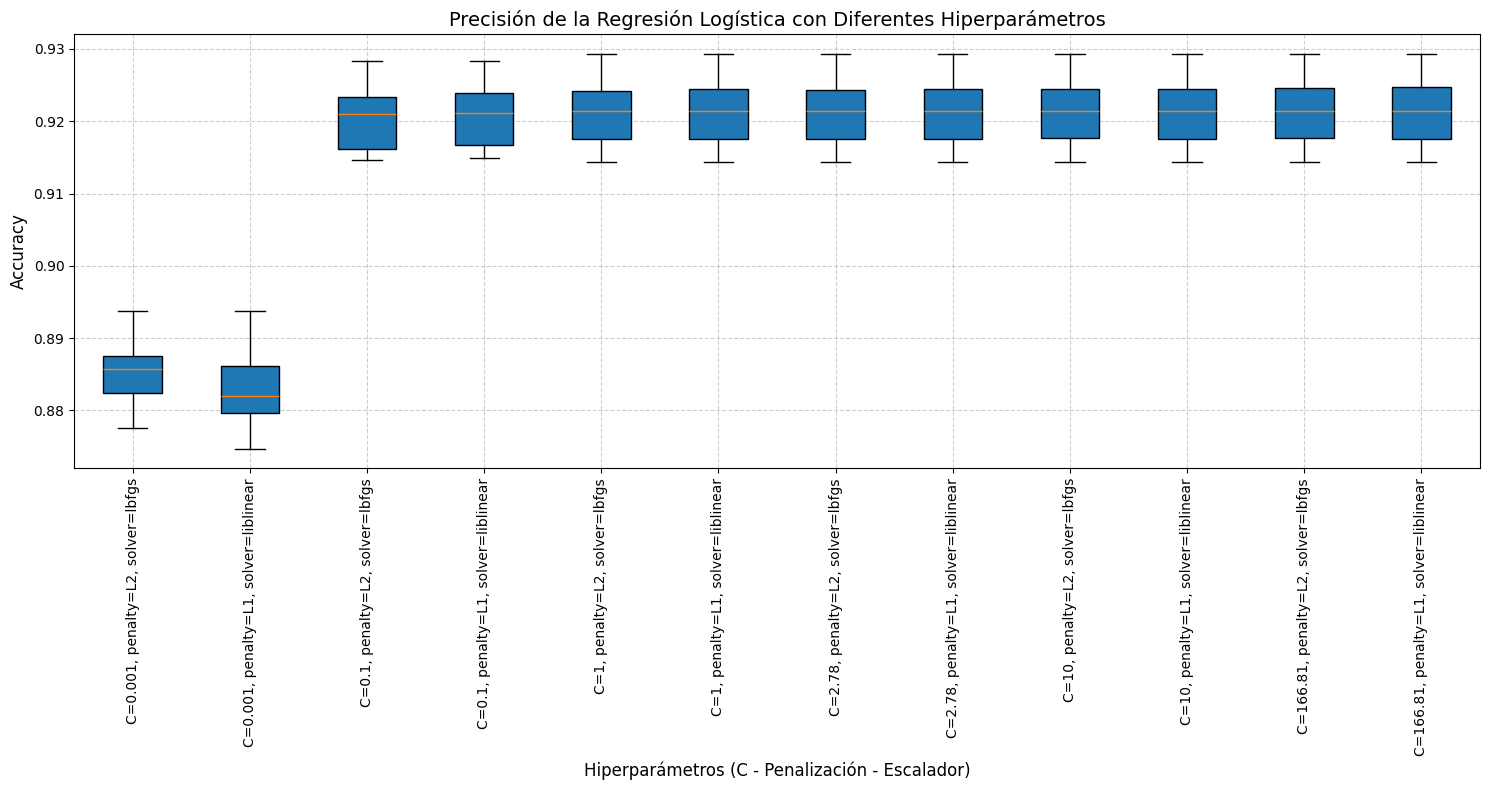

In [58]:
# Graficar los resultados
plt.figure(figsize=(15, 8))

# Configurar etiquetas para los hiperparámetros
#tick_labels = [f'C={C}, {penalty.upper()}, {solver_types[penalty]}, {scaler}' for C, penalty, scaler in param_combinations]
tick_labels = [
    f'C={C}, penalty={penalty.upper()}, solver={solver_types.get(penalty, "Unknown")}'
    for C, penalty, scaler in param_combinations
]
# Crear el boxplot
plt.boxplot(results, vert=True, patch_artist=True, meanline=True)
plt.xticks(ticks=np.arange(1, len(tick_labels) + 1), labels=tick_labels, rotation=90, fontsize=10)
plt.xlabel('Hiperparámetros (C - Penalización - Escalador)', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Precisión de la Regresión Logística con Diferentes Hiperparámetros', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()
